In [1]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os
import glob
from tqdm import tqdm
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Pre-processing

## Satellite data downloading 

In [2]:
def get_data(input_folder):
    jp2_files = glob.glob(os.path.join(input_folder, '**', '*TCI.jp2'), recursive=True)
    jp2_files_10m = glob.glob(os.path.join(input_folder, '**', '*TCI_20m.jp2'), recursive=True)
    jp2_files.extend(jp2_files_10m)
    jp2_paths = []
    for file in jp2_files:
        jp2_paths.append(Path(file))
    return jp2_paths

In [3]:
input_folder = "/Users/sergej/Desktop/Course Project/data-sentiell_2nd_try"

In [4]:
output_folder = '/Users/sergej/Desktop/Course Project/data-sentinel-processed'

In [5]:
jp2_paths = get_data(input_folder)

In [6]:
jp2_paths

[PosixPath('/Users/sergej/Desktop/Course Project/data-sentiell_2nd_try/S2A_MSIL2A_20200914T104031_N0214_R008_T32UMF_20200914T133417.SAFE/GRANULE/L2A_T32UMF_A027318_20200914T104442/IMG_DATA/R20m/T32UMF_20200914T104031_TCI_20m.jp2'),
 PosixPath('/Users/sergej/Desktop/Course Project/data-sentiell_2nd_try/S2A_MSIL2A_20200901T103031_N0500_R108_T32UPG_20230418T003836.SAFE/GRANULE/L2A_T32UPG_A027132_20200901T103505/IMG_DATA/R20m/T32UPG_20200901T103031_TCI_20m.jp2'),
 PosixPath('/Users/sergej/Desktop/Course Project/data-sentiell_2nd_try/S2A_MSIL2A_20200914T104031_N0500_R008_T32UNG_20230417T053938.SAFE/GRANULE/L2A_T32UNG_A027318_20200914T104442/IMG_DATA/R20m/T32UNG_20200914T104031_TCI_20m.jp2'),
 PosixPath('/Users/sergej/Desktop/Course Project/data-sentiell_2nd_try/S2A_MSIL2A_20200901T103031_N0500_R108_T32VPH_20230418T003836.SAFE/GRANULE/L2A_T32VPH_A027132_20200901T103505/IMG_DATA/R20m/T32VPH_20200901T103031_TCI_20m.jp2'),
 PosixPath('/Users/sergej/Desktop/Course Project/data-sentiell_2nd_try/S

In [7]:
def load_images(image_paths):
    images = []

    for image_path in image_paths:
        # Открываем изображение и собираем метаданные
        with rasterio.open(image_path) as src:
            images.append({
                'path': image_path,
                'crs': src.crs,
                'transform': src.transform,
                'width': src.width,
                'height': src.height,
                'resolution': src.res[0]  # Предполагаем, что разрешение одинаково по X и Y
            })

    return images

In [8]:
images = load_images(jp2_paths)

In [9]:
images

[{'path': PosixPath('/Users/sergej/Desktop/Course Project/data-sentiell_2nd_try/S2A_MSIL2A_20200914T104031_N0214_R008_T32UMF_20200914T133417.SAFE/GRANULE/L2A_T32UMF_A027318_20200914T104442/IMG_DATA/R20m/T32UMF_20200914T104031_TCI_20m.jp2'),
  'crs': CRS.from_epsg(32632),
  'transform': Affine(20.0, 0.0, 399960.0,
         0.0, -20.0, 6100020.0),
  'width': 5490,
  'height': 5490,
  'resolution': 20.0},
 {'path': PosixPath('/Users/sergej/Desktop/Course Project/data-sentiell_2nd_try/S2A_MSIL2A_20200901T103031_N0500_R108_T32UPG_20230418T003836.SAFE/GRANULE/L2A_T32UPG_A027132_20200901T103505/IMG_DATA/R20m/T32UPG_20200901T103031_TCI_20m.jp2'),
  'crs': CRS.from_epsg(32632),
  'transform': Affine(20.0, 0.0, 600000.0,
         0.0, -20.0, 6200040.0),
  'width': 5490,
  'height': 5490,
  'resolution': 20.0},
 {'path': PosixPath('/Users/sergej/Desktop/Course Project/data-sentiell_2nd_try/S2A_MSIL2A_20200914T104031_N0500_R008_T32UNG_20230417T053938.SAFE/GRANULE/L2A_T32UNG_A027318_20200914T104442

In [10]:
def get_scl_data(input_folder):
    scl_files = glob.glob(os.path.join(input_folder, '**', '*SCL_20m.jp2'), recursive=True)
    scl_paths = [Path(file) for file in scl_files]
    return scl_paths

In [11]:
scl_paths = get_scl_data(input_folder)

In [12]:
def check_image_metadata(images):
    # Берем параметры первого изображения для сравнения
    reference_image = images[0]
    reference_crs = reference_image['crs']
    reference_width = reference_image['width']
    reference_height = reference_image['height']
    reference_resolution = reference_image['resolution']

    for img in images:
        if img['crs'] != reference_crs:
            print(f"Изображение {img['path']} имеет другую систему координат (CRS)")
            return False
        if img['width'] != reference_width or img['height'] != reference_height:
            print(f"Изображение {img['path']} имеет другое разрешение или размеры (ширина, высота)")
            return False
        if img['resolution'] != reference_resolution:
            print(f"Изображение {img['path']} имеет другое пространственное разрешение")
            return False

    print("All images have the same parametrs")
    return True

In [13]:
check_image_metadata(images)

All images have the same parametrs


True

In [14]:
if len(jp2_paths) == 0:
    print("Files TCI.jp2 were not found.")
else:
    for jp2_file in jp2_paths:
        print(f"Found file: {jp2_file}")

        # Opening file with rasterio and output metadata
        try:
            with rasterio.open(jp2_file) as src:
                print(f"Файл: {jp2_file.name}")
                print(f"  - Размеры (ширина x высота): {src.width} x {src.height}")
                print(f"  - Количество каналов: {src.count}")
                print(f"  - Тип данных (dtype): {src.dtypes[0]}")
                print(f"  - Разрешение (pixel size): {src.res}")
                print(f"  - CRS (система координат): {src.crs}")
                print(f"  - Границы (bounding box): {src.bounds}")
                print(f"  - Трансформация: {src.transform}")
                print()
        except Exception as e:
            print(f"Couldn't open the file {jp2_file}: {e}")

Found file: /Users/sergej/Desktop/Course Project/data-sentiell_2nd_try/S2A_MSIL2A_20200914T104031_N0214_R008_T32UMF_20200914T133417.SAFE/GRANULE/L2A_T32UMF_A027318_20200914T104442/IMG_DATA/R20m/T32UMF_20200914T104031_TCI_20m.jp2
Файл: T32UMF_20200914T104031_TCI_20m.jp2
  - Размеры (ширина x высота): 5490 x 5490
  - Количество каналов: 3
  - Тип данных (dtype): uint8
  - Разрешение (pixel size): (20.0, 20.0)
  - CRS (система координат): EPSG:32632
  - Границы (bounding box): BoundingBox(left=399960.0, bottom=5990220.0, right=509760.0, top=6100020.0)
  - Трансформация: | 20.00, 0.00, 399960.00|
| 0.00,-20.00, 6100020.00|
| 0.00, 0.00, 1.00|

Found file: /Users/sergej/Desktop/Course Project/data-sentiell_2nd_try/S2A_MSIL2A_20200901T103031_N0500_R108_T32UPG_20230418T003836.SAFE/GRANULE/L2A_T32UPG_A027132_20200901T103505/IMG_DATA/R20m/T32UPG_20200901T103031_TCI_20m.jp2
Файл: T32UPG_20200901T103031_TCI_20m.jp2
  - Размеры (ширина x высота): 5490 x 5490
  - Количество каналов: 3
  - Тип данны

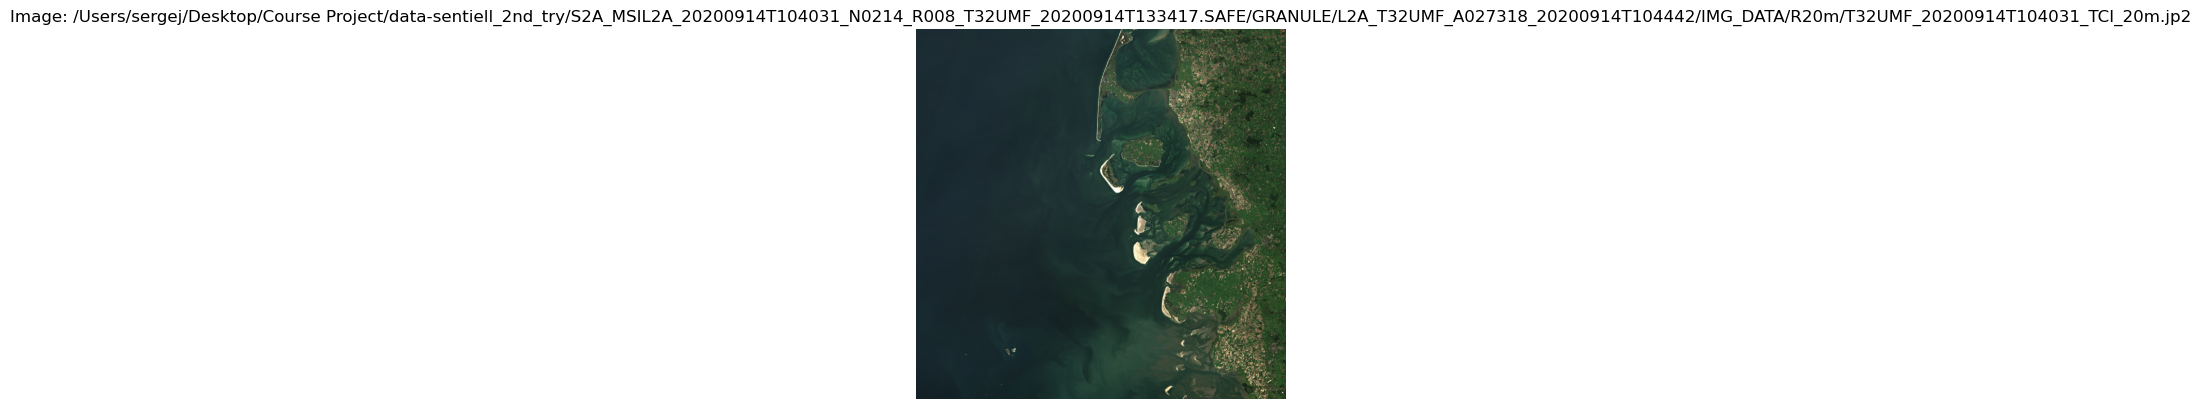

In [15]:
with rasterio.open(jp2_paths[0]) as src:
    image = src.read([1, 2, 3])  

image = np.moveaxis(image, 0, -1)

plt.imshow(image)
plt.title(f"Image: {jp2_paths[0]}")
plt.axis('off')  # Отключаем оси для эстетики
plt.show()

## Function for processing the data

In [16]:
def reproject_img(images, output_dir):
    # Reference CRS is taken from the first image
    reference_crs = images[0]['crs']
    
    for img in images:
        if img['crs'] != reference_crs:
            input_path = img['path']
            output_path = Path(output_dir) / f"{input_path.stem}_reprojected{input_path.suffix}"
            with rasterio.open(input_path) as src:
                transform, width, height = calculate_default_transform(
                    src.crs, reference_crs, src.width, src.height, *src.bounds
                )
                kwargs = src.meta.copy()
                kwargs.update({
                    'crs': reference_crs,
                    'transform': transform,
                    'width': width,
                    'height': height
                })
                with rasterio.open(output_path, 'w', **kwargs) as dst:
                    for i in range(1, src.count + 1):
                        reproject(
                            source=rasterio.band(src, i),
                            destination=rasterio.band(dst, i),
                            src_transform=src.transform,
                            src_crs=src.crs,
                            dst_transform=transform,
                            dst_crs=reference_crs,
                            resampling=Resampling.nearest
                        )
            print(f"Изображение {input_path} репроецировано в {output_path}")
        else:
            print(f"Изображение {img['path']} уже в требуемой CRS")

In [17]:
def handle_nodata(input_path, output_path, nodata_value=0):
    with rasterio.open(input_path) as src:
        kwargs = src.meta.copy()
        kwargs.update(nodata=nodata_value)

        with rasterio.open(output_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                # Чтение данных
                data = src.read(i)
                # Заменяем NoData значение на указанное
                data[data == src.nodata] = nodata_value
                dst.write(data, i)

In [18]:
def apply_scl_mask(image_path, scl_path, output_path, mask_classes=[3, 6, 8, 9, 10]): 
    with rasterio.open(image_path) as src:
        image = src.read() 
        profile = src.profile  
    with rasterio.open(scl_path) as scl_src:
        scl = scl_src.read(1)  
    
    mask = np.isin(scl, mask_classes)

    masked_image = np.where(mask, 0, image)

    # Downloading the result
    
    profile.update(dtype=rasterio.uint8)

    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(masked_image)

    return masked_image

## Applying SCL masks to the satellite images  

In [19]:
def apply_masks_to_images(image_paths, scl_paths, output_paths, mask_classes=[3, 6, 8, 9, 10]):

    for image_path, scl_path, output_path in zip(image_paths, scl_paths, output_paths):
        print(f"Processing image: {image_path} with mask: {scl_path}")
        apply_scl_mask(image_path, scl_path, output_path, mask_classes)
        print(f"Saved masked image to: {output_path}")

In [20]:
image_paths = jp2_paths
scl_paths = get_scl_data(input_folder)

In [21]:
assert len(image_paths) == len(scl_paths), "Number of images and masks is not the same."

In [22]:
output_paths = [str(Path(img).with_name(f"{Path(img).stem}_masked.tif")) for img in image_paths]

In [23]:
apply_masks_to_images(image_paths, scl_paths, output_paths)

Processing image: /Users/sergej/Desktop/Course Project/data-sentiell_2nd_try/S2A_MSIL2A_20200914T104031_N0214_R008_T32UMF_20200914T133417.SAFE/GRANULE/L2A_T32UMF_A027318_20200914T104442/IMG_DATA/R20m/T32UMF_20200914T104031_TCI_20m.jp2 with mask: /Users/sergej/Desktop/Course Project/data-sentiell_2nd_try/S2A_MSIL2A_20200914T104031_N0214_R008_T32UMF_20200914T133417.SAFE/GRANULE/L2A_T32UMF_A027318_20200914T104442/IMG_DATA/R20m/T32UMF_20200914T104031_SCL_20m.jp2
Saved masked image to: /Users/sergej/Desktop/Course Project/data-sentiell_2nd_try/S2A_MSIL2A_20200914T104031_N0214_R008_T32UMF_20200914T133417.SAFE/GRANULE/L2A_T32UMF_A027318_20200914T104442/IMG_DATA/R20m/T32UMF_20200914T104031_TCI_20m_masked.tif
Processing image: /Users/sergej/Desktop/Course Project/data-sentiell_2nd_try/S2A_MSIL2A_20200901T103031_N0500_R108_T32UPG_20230418T003836.SAFE/GRANULE/L2A_T32UPG_A027132_20200901T103505/IMG_DATA/R20m/T32UPG_20200901T103031_TCI_20m.jp2 with mask: /Users/sergej/Desktop/Course Project/data-se

In [24]:
output_paths = [Path(p) for p in output_paths]

# Mosaic creation

In [25]:
if check_image_metadata(images) != True:
    reproject_img(images, output_folder)

All images have the same parametrs


In [26]:
from rasterio.merge import merge
import rasterio
mosaic, out_trans = merge(output_paths)

In [27]:
import rasterio
from rasterio.transform import from_origin

output_file = '/Users/sergej/Desktop/Course Project/data-sentinel-processed/output_mosaic.tif'  # Укажите путь к выходному файлу

# Determine the metadata for the file 
metadata = {
    'driver': 'GTiff',
    'count': mosaic.shape[0],  
    'dtype': mosaic.dtype,
    'width': mosaic.shape[2],
    'height': mosaic.shape[1],
    'crs': 'EPSG:32632', 
    'transform': out_trans,
}

# Downloading the mosaic
with rasterio.open(output_file, 'w', **metadata) as dst:
    for i in range(metadata['count']):
        dst.write(mosaic[i, :, :], i + 1)


# Post-processing, compressing the mosaic

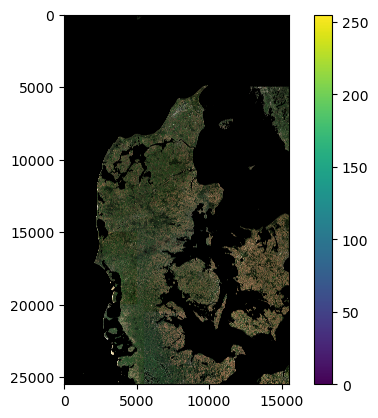

In [29]:
import matplotlib.pyplot as plt

# Transpose the array to (height, width, channels)
plt.imshow(mosaic.transpose(1, 2, 0))
plt.colorbar()
plt.show()

In [30]:
import rasterio
from rasterio.enums import Compression

def compress_tif(input_tif, output_tif, compression='lzw'):

    with rasterio.open(input_tif) as src:
        # Getting metadata of the given file
        profile = src.profile  
        # Updating profile
        profile.update(compress=compression)   

        data = src.read()

        #Downloading the compressed file
        with rasterio.open(output_tif, 'w', **profile) as dst:
            dst.write(data)

In [31]:
input_tif = "/Users/sergej/Desktop/Course Project/data-sentinel-processed/output_mosaic.tif"
output_tif = "/Users/sergej/Desktop/Course Project/data-sentinel-processed/compressed_mosaic.tif"

compress_tif(input_tif, output_tif, compression='lzw')